<a href="https://www.kaggle.com/code/yovipi/football-predictor-model-ipynb?scriptVersionId=270368239" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# The Beautiful Game Oracle — Baseline TensorFlow Suite

This notebook prepares and compares three TensorFlow/Keras baseline models for predicting English Premier League match outcomes using data pulled directly from the Understat API. It aligns with the project charter in `README.md` and the agent directives in `AGENTS.md`, emphasising reproducible experiments, attribution readiness, and run tracking for longitudinal comparisons.



## Workflow Overview
- Fetch and cache historical EPL match data from Understat for configurable seasons.
- Engineer team form, momentum, and market-derived features compatible with TensorFlow pipelines.
- Train three complementary baselines (performance-form dense net, momentum interaction network, forecast calibrator) and save artefacts for reuse.
- Persist metrics and artefacts per run, append to a cumulative history log, and generate comparison visuals versus prior runs.
- Prepare the infrastructure needed for downstream attribution work (Shapley/LOO) by keeping models and datasets aligned with saved run metadata.


## Environment Setup

In [1]:

import os
import json
import math
import time
import re
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import requests
import tensorflow as tf
from tensorflow import keras
from IPython.display import display

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
pd.options.display.max_columns = 100

SEED = 42
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)


2025-10-23 20:04:03.806964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761249844.020490      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761249844.073642      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Experiment Configuration

In [2]:

# Experiment configuration
PROJECT_NAME = "The-Beautiful-Game-Oracle"
LEAGUE = "EPL"
SEASONS = ["2023", "2022", "2021", "2020"]  # extend or adjust as needed
ROLLING_WINDOW = 5
BATCH_SIZE = 64
EPOCHS = 50
REFRESH_DATA = False  # set True to refetch from Understat
RUN_ID = datetime.utcnow().strftime("%Y%m%d-%H%M%S")

# Filesystem locations (compatible with Kaggle + local use)
if Path("/kaggle").exists():
    BASE_WORKING_DIR = Path("/kaggle/working")
else:
    BASE_WORKING_DIR = Path("./artifacts")

EXPERIMENT_ROOT = BASE_WORKING_DIR / "experiments"
CACHE_DIR = EXPERIMENT_ROOT / "understat_cache"
MODEL_ARTIFACT_DIR = EXPERIMENT_ROOT / f"run_{RUN_ID}"
RUN_LOG_PATH = EXPERIMENT_ROOT / "baseline_run_history.csv"

for path in [EXPERIMENT_ROOT, CACHE_DIR, MODEL_ARTIFACT_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project: {PROJECT_NAME}")
print(f"Seasons loaded: {SEASONS}")
print(f"Working dir: {BASE_WORKING_DIR.resolve()}")
print(f"Current run artefacts: {MODEL_ARTIFACT_DIR}")


Project: The-Beautiful-Game-Oracle
Seasons loaded: ['2023', '2022', '2021', '2020']
Working dir: /kaggle/working
Current run artefacts: /kaggle/working/experiments/run_20251023-200415


## Data Acquisition

In [3]:

# Understat data retrieval helpers
HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; The-Beautiful-Game-Oracle/1.0)",
}

MATCHES_PATTERN = re.compile(r"var\s+datesData\s*=\s*JSON.parse\('(.+?)'\)")


def fetch_understat_dates(league: str, season: str, *, refresh: bool = False) -> list:
    '''Download Understat league matches for a season, with on-disk caching.'''
    cache_path = CACHE_DIR / f"{league}_{season}_dates.json"
    if cache_path.exists() and not refresh:
        try:
            return json.loads(cache_path.read_text())
        except json.JSONDecodeError:
            pass  # fall back to refetching

    url = f"https://understat.com/league/{league}/{season}"
    response = requests.get(url, headers=HEADERS, timeout=30)
    response.raise_for_status()
    match = MATCHES_PATTERN.search(response.text)
    if not match:
        raise RuntimeError(f"datesData block not found for {league} {season}")
    decoded = match.group(1).encode("utf-8").decode("unicode_escape")
    data = json.loads(decoded)
    cache_path.write_text(json.dumps(data))
    time.sleep(0.5)  # be gentle with the source
    return data


def load_matches_for_seasons(league: str, seasons: list[str], refresh: bool = False) -> dict[str, list]:
    payload = {}
    for season in seasons:
        payload[season] = fetch_understat_dates(league, season, refresh=refresh)
        print(f"Loaded {len(payload[season])} fixtures for {league} {season}")
    return payload


## Feature Engineering Utilities

In [4]:

# Feature engineering utilities
from typing import Dict, List, Tuple

CLASS_LABELS = ["Home Win", "Draw", "Away Win"]


def build_match_dataframe(matches_by_season: Dict[str, List[dict]]) -> pd.DataFrame:
    rows = []
    for season, matches in matches_by_season.items():
        for match in matches:
            if not match.get("isResult"):
                continue  # skip fixtures without a final result
            rows.append({
                "match_id": int(match["id"]),
                "season": season,
                "match_date": pd.to_datetime(match["datetime"], format="%Y-%m-%d %H:%M:%S"),
                "home_team": match["h"]["title"],
                "away_team": match["a"]["title"],
                "home_goals": int(match["goals"]["h"]),
                "away_goals": int(match["goals"]["a"]),
                "home_xg": float(match["xG"]["h"]),
                "away_xg": float(match["xG"]["a"]),
                "home_prob_win": float(match["forecast"]["w"]),
                "draw_prob": float(match["forecast"]["d"]),
                "away_prob_win": float(match["forecast"]["l"]),
            })
    frame = pd.DataFrame(rows).sort_values("match_date").reset_index(drop=True)
    print(f"Prepared {len(frame)} completed fixtures across seasons {sorted(matches_by_season.keys())}")
    return frame


def build_team_match_rows(match_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for row in match_df.itertuples(index=False):
        rows.append({
            "match_id": row.match_id,
            "season": row.season,
            "match_date": row.match_date,
            "team": row.home_team,
            "opponent": row.away_team,
            "is_home": 1,
            "goals_for": row.home_goals,
            "goals_against": row.away_goals,
            "xg_for": row.home_xg,
            "xg_against": row.away_xg,
            "prob_win": row.home_prob_win,
            "prob_loss": row.away_prob_win,
            "draw_prob": row.draw_prob,
        })
        rows.append({
            "match_id": row.match_id,
            "season": row.season,
            "match_date": row.match_date,
            "team": row.away_team,
            "opponent": row.home_team,
            "is_home": 0,
            "goals_for": row.away_goals,
            "goals_against": row.home_goals,
            "xg_for": row.away_xg,
            "xg_against": row.home_xg,
            "prob_win": row.away_prob_win,
            "prob_loss": row.home_prob_win,
            "draw_prob": row.draw_prob,
        })
    team_df = pd.DataFrame(rows).sort_values("match_date").reset_index(drop=True)
    team_df["goal_diff"] = team_df["goals_for"] - team_df["goals_against"]
    team_df["xg_diff"] = team_df["xg_for"] - team_df["xg_against"]
    return team_df


def add_form_features(team_df: pd.DataFrame, window: int = 5) -> pd.DataFrame:
    feature_cols = [
        "goals_for",
        "goals_against",
        "goal_diff",
        "xg_for",
        "xg_against",
        "xg_diff",
        "prob_win",
    ]

    def enrich(group: pd.DataFrame) -> pd.DataFrame:
        g = group.copy()
        for col in feature_cols:
            shifted = g[col].shift(1)
            g[f"form_{col}_mean"] = shifted.rolling(window, min_periods=1).mean().fillna(0)
            g[f"form_{col}_std"] = shifted.rolling(window, min_periods=1).std().fillna(0)
            g[f"form_{col}_last"] = shifted.fillna(0)
        return g

    enriched = (
        team_df.sort_values("match_date")
        .groupby("team", group_keys=False)
        .apply(enrich)
        .reset_index(drop=True)
    )
    return enriched


def assemble_match_features(team_form_df: pd.DataFrame) -> pd.DataFrame:
    keep_cols = ["match_id", "season", "match_date", "home_team", "away_team"]

    home = team_form_df[team_form_df["is_home"] == 1].copy()
    away = team_form_df[team_form_df["is_home"] == 0].copy()

    home.rename(columns={"team": "home_team", "opponent": "away_team"}, inplace=True)
    away.rename(columns={"team": "away_team", "opponent": "home_team"}, inplace=True)

    def prefix_except(df: pd.DataFrame, prefix: str, exclude: List[str]) -> pd.DataFrame:
        rename_map = {col: f"{prefix}{col}" for col in df.columns if col not in exclude}
        return df.rename(columns=rename_map)

    home_prefixed = prefix_except(home, "home_", keep_cols)
    away_prefixed = prefix_except(away, "away_", keep_cols)

    merged = home_prefixed.merge(
        away_prefixed,
        on=["match_id", "season", "match_date", "home_team", "away_team"],
        how="inner",
        suffixes=("", "_dup"),
    )

    if "home_draw_prob" in merged.columns:
        merged.rename(columns={"home_draw_prob": "match_draw_prob"}, inplace=True)
    if "away_draw_prob" in merged.columns:
        merged.drop(columns=["away_draw_prob"], inplace=True)

    merged["target"] = np.select(
        [
            merged["home_goals_for"] > merged["away_goals_for"],
            merged["home_goals_for"] == merged["away_goals_for"],
        ],
        [0, 1],
        default=2,
    )

    merged.sort_values("match_date", inplace=True)
    merged.reset_index(drop=True, inplace=True)
    return merged


def build_feature_deltas(match_df: pd.DataFrame) -> pd.DataFrame:
    df = match_df.copy()
    df["form_goal_diff_delta"] = df["home_form_goal_diff_mean"] - df["away_form_goal_diff_mean"]
    df["form_xg_diff_delta"] = df["home_form_xg_diff_mean"] - df["away_form_xg_diff_mean"]
    df["form_prob_win_delta"] = df["home_form_prob_win_mean"] - df["away_form_prob_win_mean"]
    df["form_goal_last_delta"] = df["home_form_goal_diff_last"] - df["away_form_goal_diff_last"]
    df["form_xg_last_delta"] = df["home_form_xg_diff_last"] - df["away_form_xg_diff_last"]
    df["prob_edge"] = df["home_prob_win"] - df["away_prob_win"]
    return df


## Dataset Assembly

In [5]:

# Load and prepare datasets
matches_payload = load_matches_for_seasons(LEAGUE, SEASONS, refresh=REFRESH_DATA)
match_df = build_match_dataframe(matches_payload)
team_df = build_team_match_rows(match_df)
team_form_df = add_form_features(team_df, window=ROLLING_WINDOW)
match_features_df = assemble_match_features(team_form_df)
match_features_df = build_feature_deltas(match_features_df)

feature_columns = [col for col in match_features_df.columns if col.startswith(("home_", "away_", "form_", "match_", "prob_"))]
match_features_df[feature_columns] = match_features_df[feature_columns].fillna(0)

print(f"Final feature table: {match_features_df.shape[0]} matches x {len(feature_columns)} engineered columns")
display(match_features_df.head())


Loaded 380 fixtures for EPL 2023
Loaded 380 fixtures for EPL 2022
Loaded 380 fixtures for EPL 2021
Loaded 380 fixtures for EPL 2020
Prepared 1520 completed fixtures across seasons ['2020', '2021', '2022', '2023']
Final feature table: 1520 matches x 71 engineered columns


/tmp/ipykernel_37/2460395925.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(enrich)


,match_id,season,match_date,home_team,away_team,home_is_home,home_goals_for,home_goals_against,home_xg_for,home_xg_against,home_prob_win,home_prob_loss,match_draw_prob,home_goal_diff,home_xg_diff,home_form_goals_for_mean,home_form_goals_for_std,home_form_goals_for_last,home_form_goals_against_mean,home_form_goals_against_std,home_form_goals_against_last,home_form_goal_diff_mean,home_form_goal_diff_std,home_form_goal_diff_last,home_form_xg_for_mean,home_form_xg_for_std,home_form_xg_for_last,home_form_xg_against_mean,home_form_xg_against_std,home_form_xg_against_last,home_form_xg_diff_mean,home_form_xg_diff_std,home_form_xg_diff_last,home_form_prob_win_mean,home_form_prob_win_std,home_form_prob_win_last,away_is_home,away_goals_for,away_goals_against,away_xg_for,away_xg_against,away_prob_win,away_prob_loss,away_goal_diff,away_xg_diff,away_form_goals_for_mean,away_form_goals_for_std,away_form_goals_for_last,away_form_goals_against_mean,away_form_goals_against_std,away_form_goals_against_last,away_form_goal_diff_mean,away_form_goal_diff_std,away_form_goal_diff_last,away_form_xg_for_mean,away_form_xg_for_std,away_form_xg_for_last,away_form_xg_against_mean,away_form_xg_against_std,away_form_xg_against_last,away_form_xg_diff_mean,away_form_xg_diff_std,away_form_xg_diff_last,away_form_prob_win_mean,away_form_prob_win_std,away_form_prob_win_last,target,form_goal_diff_delta,form_xg_diff_delta,form_prob_win_delta,form_goal_last_delta,form_xg_last_delta,prob_edge
0,14086,2020,2020-09-12 11:30:00,Fulham,Arsenal,1,0,3,0.126327,2.162870,0.0037,0.9487,0.0476,-3,-2.036543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,2.162870,0.126327,0.9487,0.0037,3,2.036543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,-0.9450
1,14087,2020,2020-09-12 14:00:00,Crystal Palace,Southampton,1,1,0,1.395690,1.262670,0.3916,0.3062,0.3022,1,0.133020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1.262670,1.395690,0.3062,0.3916,-1,-0.133020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0854
2,14090,2020,2020-09-12 16:30:00,Liverpool,Leeds,1,4,3,3.154120,0.269813,0.9658,0.0046,0.0296,1,2.884307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,4,0.269813,3.154120,0.0046,0.9658,-1,-2.884307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.9612
3,14091,2020,2020-09-12 19:00:00,West Ham,Newcastle United,1,0,2,0.861445,1.659110,0.1506,0.6014,0.2480,-2,-0.797665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,1.659110,0.861445,0.6014,0.1506,2,0.797665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,-0.4508
4,14092,2020,2020-09-13 13:00:00,West Bromwich Albion,Leicester,1,0,3,0.352997,2.955810,0.0070,0.9572,0.0358,-3,-2.602813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,2.955810,0.352997,0.9572,0.0070,3,2.602813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,-0.9502


## Train/Validation/Test Split

In [6]:

# Chronological train/validation/test split
sorted_df = match_features_df.sort_values("match_date").reset_index(drop=True)
num_matches = len(sorted_df)
train_end = int(num_matches * 0.6)
val_end = int(num_matches * 0.8)

split_indices = {
    "train": sorted_df.index[:train_end],
    "val": sorted_df.index[train_end:val_end],
    "test": sorted_df.index[val_end:],
}

print({k: len(v) for k, v in split_indices.items()})


{'train': 912, 'val': 304, 'test': 304}


## Feature Views

In [7]:

# Feature sets aligned with the three data perspectives outlined in README.md
PERFORMANCE_FEATURES = [
    "home_form_goals_for_mean",
    "home_form_goals_against_mean",
    "home_form_goal_diff_mean",
    "home_form_xg_for_mean",
    "home_form_xg_against_mean",
    "home_form_xg_diff_mean",
    "away_form_goals_for_mean",
    "away_form_goals_against_mean",
    "away_form_goal_diff_mean",
    "away_form_xg_for_mean",
    "away_form_xg_against_mean",
    "away_form_xg_diff_mean",
    "form_goal_diff_delta",
    "form_xg_diff_delta",
]

MOMENTUM_FEATURES = [
    "home_form_goal_diff_last",
    "home_form_xg_diff_last",
    "home_form_goal_diff_std",
    "away_form_goal_diff_last",
    "away_form_xg_diff_last",
    "away_form_goal_diff_std",
    "form_goal_last_delta",
    "form_xg_last_delta",
    "form_goal_diff_delta",
    "form_xg_diff_delta",
    "form_prob_win_delta",
]

MARKET_FEATURES = [
    "home_prob_win",
    "home_prob_loss",
    "away_prob_win",
    "away_prob_loss",
    "match_draw_prob",
    "home_form_prob_win_mean",
    "away_form_prob_win_mean",
    "form_prob_win_delta",
    "prob_edge",
]

FEATURE_SETS = {
    "performance_dense": {
        "description": "Performance-based dense network using rolling xG/goals form aggregates",
        "feature_cols": PERFORMANCE_FEATURES,
    },
    "momentum_interaction": {
        "description": "Momentum interaction MLP on recent differential form signals",
        "feature_cols": MOMENTUM_FEATURES,
    },
    "forecast_calibrator": {
        "description": "Understat forecast calibrator focusing on market-style probabilities",
        "feature_cols": MARKET_FEATURES,
    },
}

print({name: len(spec["feature_cols"]) for name, spec in FEATURE_SETS.items()})


{'performance_dense': 14, 'momentum_interaction': 11, 'forecast_calibrator': 9}


## TensorFlow Dataset Utilities

In [8]:

# Dataset constructors

def build_xy(df: pd.DataFrame, feature_cols: list[str], indices: pd.Index) -> tuple[np.ndarray, np.ndarray]:
    X = df.loc[indices, feature_cols].astype(np.float32).to_numpy()
    y = df.loc[indices, "target"].astype(np.int32).to_numpy()
    return X, y


def make_dataset(X: np.ndarray, y: np.ndarray, *, training: bool) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


def compute_class_weights(y: np.ndarray) -> dict[int, float]:
    counts = np.bincount(y, minlength=len(CLASS_LABELS))
    total = float(len(y))
    weights = {cls: total / (len(CLASS_LABELS) * count) for cls, count in enumerate(counts) if count > 0}
    return weights


## Baseline Model Builders

### Performance Dense Baseline

In [9]:
def build_performance_model(input_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="performance_features")
    x = keras.layers.Dense(64, activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dropout(0.15)(x)
    outputs = keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="performance_dense")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


### Momentum Interaction Baseline

In [10]:
def build_momentum_model(input_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="momentum_features")
    x = keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(inputs)
    x = keras.layers.Dropout(0.35)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    outputs = keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="momentum_interaction")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=7e-4),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


### Forecast Calibrator Baseline

In [11]:
def build_forecast_model(input_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="forecast_features")
    x = keras.layers.Dense(32, activation="relu")(inputs)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.Dense(16, activation="relu")(x)
    outputs = keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="forecast_calibrator")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


### Baseline Registry

In [12]:
BASELINE_BUILDERS = {
    "performance_dense": build_performance_model,
    "momentum_interaction": build_momentum_model,
    "forecast_calibrator": build_forecast_model,
}


## Training and Run Logging

In [13]:

# Training loop with experiment logging
sce = keras.losses.SparseCategoricalCrossentropy()

baseline_results = []
run_log_entries = []

for baseline_name, spec in FEATURE_SETS.items():
    feature_cols = spec["feature_cols"]
    builder = BASELINE_BUILDERS[baseline_name]

    X_train, y_train = build_xy(sorted_df, feature_cols, split_indices["train"])
    X_val, y_val = build_xy(sorted_df, feature_cols, split_indices["val"])
    X_test, y_test = build_xy(sorted_df, feature_cols, split_indices["test"])

    train_ds = make_dataset(X_train, y_train, training=True)
    val_ds = make_dataset(X_val, y_val, training=False)
    test_ds = make_dataset(X_test, y_test, training=False)

    model = builder(len(feature_cols))
    class_weights = compute_class_weights(y_train)

    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=2,
    )

    train_metrics = model.evaluate(train_ds, verbose=0)
    val_metrics = model.evaluate(val_ds, verbose=0)
    test_metrics = model.evaluate(test_ds, verbose=0)

    val_probs = model.predict(val_ds, verbose=0)
    test_probs = model.predict(test_ds, verbose=0)
    val_preds = np.argmax(val_probs, axis=1)
    test_preds = np.argmax(test_probs, axis=1)

    val_accuracy = float(np.mean(val_preds == y_val))
    test_accuracy = float(np.mean(test_preds == y_test))
    val_logloss = float(sce(y_val, val_probs).numpy())
    test_logloss = float(sce(y_test, test_probs).numpy())

    confusion = tf.math.confusion_matrix(y_test, test_preds, num_classes=len(CLASS_LABELS)).numpy()

    baseline_dir = MODEL_ARTIFACT_DIR / baseline_name
    baseline_dir.mkdir(parents=True, exist_ok=True)
    model.save(baseline_dir / "model.keras", include_optimizer=False)
    with open(baseline_dir / "history.json", "w") as fp:
        json.dump(history.history, fp, indent=2)
    with open(baseline_dir / "metrics.json", "w") as fp:
        json.dump({
            "train": {"loss": float(train_metrics[0]), "accuracy": float(train_metrics[1])},
            "val": {"loss": float(val_metrics[0]), "accuracy": float(val_metrics[1])},
            "test": {"loss": float(test_metrics[0]), "accuracy": float(test_metrics[1])},
            "val_logloss": val_logloss,
            "test_logloss": test_logloss,
            "class_weights": class_weights,
            "feature_cols": feature_cols,
        }, fp, indent=2)

    eval_rows = sorted_df.loc[split_indices["test"], ["match_id", "season", "match_date", "home_team", "away_team", "target"]].copy()
    eval_rows["predicted"] = test_preds
    eval_rows["predicted_label"] = eval_rows["predicted"].map(dict(enumerate(CLASS_LABELS)))
    eval_rows["target_label"] = eval_rows["target"].map(dict(enumerate(CLASS_LABELS)))
    eval_rows["home_prob"] = test_probs[:, 0]
    eval_rows["draw_prob"] = test_probs[:, 1]
    eval_rows["away_prob"] = test_probs[:, 2]
    eval_rows.to_csv(baseline_dir / "test_predictions.csv", index=False)

    def save_confusion_heatmap(cm: np.ndarray, labels: list[str], path: Path, title: str) -> None:
        fig, ax = plt.subplots(figsize=(4, 4))
        im = ax.imshow(cm, cmap="Blues")
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_yticklabels(labels)
        for i in range(len(labels)):
            for j in range(len(labels)):
                ax.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        ax.set_title(title)
        fig.colorbar(im, ax=ax)
        fig.tight_layout()
        fig.savefig(path, dpi=160)
        plt.close(fig)

    save_confusion_heatmap(confusion, CLASS_LABELS, baseline_dir / "confusion_matrix.png", f"{baseline_name} — Test Confusion")

    baseline_results.append({
        "baseline": baseline_name,
        "description": spec["description"],
        "val_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
        "val_logloss": val_logloss,
        "test_logloss": test_logloss,
        "epochs": len(history.history["loss"]),
    })

    run_log_entries.append({
        "timestamp": datetime.utcnow().isoformat(),
        "run_id": RUN_ID,
        "baseline": baseline_name,
        "feature_view": spec["description"],
        "train_accuracy": float(train_metrics[1]),
        "val_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
        "val_loss": float(val_metrics[0]),
        "test_loss": float(test_metrics[0]),
        "val_logloss": val_logloss,
        "test_logloss": test_logloss,
        "epochs_trained": len(history.history["loss"]),
        "seasons": "|".join(SEASONS),
        "notes": "",
    })

baseline_summary_df = pd.DataFrame(baseline_results).sort_values("val_accuracy", ascending=False)
display(baseline_summary_df)

if run_log_entries:
    run_log_df = pd.DataFrame(run_log_entries)
    if RUN_LOG_PATH.exists():
        run_log_df.to_csv(RUN_LOG_PATH, mode="a", header=False, index=False)
    else:
        run_log_df.to_csv(RUN_LOG_PATH, index=False)
    display(run_log_df[["baseline", "val_accuracy", "test_accuracy", "epochs_trained"]])


I0000 00:00:1761249863.646982      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761249863.647673      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1761249867.937076      97 service.cc:148] XLA service 0x7cff2400c690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761249867.937698      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761249867.937715      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761249868.194048      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761249869.905880      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 - 6s - 413ms/step - accuracy: 0.3651 - loss: 1.3596 - val_accuracy: 0.4770 - val_loss: 1.0448 - learning_rate: 0.0010
Epoch 2/50
15/15 - 0s - 4ms/step - accuracy: 0.3925 - loss: 1.2256 - val_accuracy: 0.4605 - val_loss: 1.0588 - learning_rate: 0.0010
Epoch 3/50
15/15 - 0s - 4ms/step - accuracy: 0.4232 - loss: 1.1531 - val_accuracy: 0.4572 - val_loss: 1.0650 - learning_rate: 0.0010
Epoch 4/50
15/15 - 0s - 4ms/step - accuracy: 0.4123 - loss: 1.1571 - val_accuracy: 0.4441 - val_loss: 1.0647 - learning_rate: 0.0010
Epoch 5/50
15/15 - 0s - 4ms/step - accuracy: 0.3991 - loss: 1.1036 - val_accuracy: 0.4408 - val_loss: 1.0587 - learning_rate: 5.0000e-04
Epoch 6/50
15/15 - 0s - 4ms/step - accuracy: 0.4276 - loss: 1.1061 - val_accuracy: 0.4539 - val_loss: 1.0546 - learning_rate: 5.0000e-04
Epoch 7/50
15/15 - 0s - 4ms/step - accuracy: 0.4430 - loss: 1.0870 - val_accuracy: 0.4441 - val_loss: 1.0537 - learning_rate: 5.0000e-04
Epoch 1/50
15/15 - 5s - 360ms/step - accuracy: 0.4112 - loss: 1.15

,baseline,description,val_accuracy,test_accuracy,val_logloss,test_logloss,epochs
2,forecast_calibrator,Understat forecast calibrator focusing on mark...,0.664474,0.588816,0.863253,0.876714,34
0,performance_dense,Performance-based dense network using rolling ...,0.476974,0.401316,1.044840,1.083669,7
1,momentum_interaction,Momentum interaction MLP on recent differentia...,0.476974,0.483553,1.040578,1.058125,22


,baseline,val_accuracy,test_accuracy,epochs_trained
0,performance_dense,0.476974,0.401316,7
1,momentum_interaction,0.476974,0.483553,22
2,forecast_calibrator,0.664474,0.588816,34


## Historical Comparison

Most recent run vs historical best (by validation accuracy):


,baseline,val_accuracy_current,val_accuracy_best,test_accuracy_current,test_accuracy_best,run_id_best
0,performance_dense,0.476974,0.476974,0.401316,0.401316,20251023-200415
1,momentum_interaction,0.476974,0.476974,0.483553,0.483553,20251023-200415
2,forecast_calibrator,0.664474,0.664474,0.588816,0.588816,20251023-200415


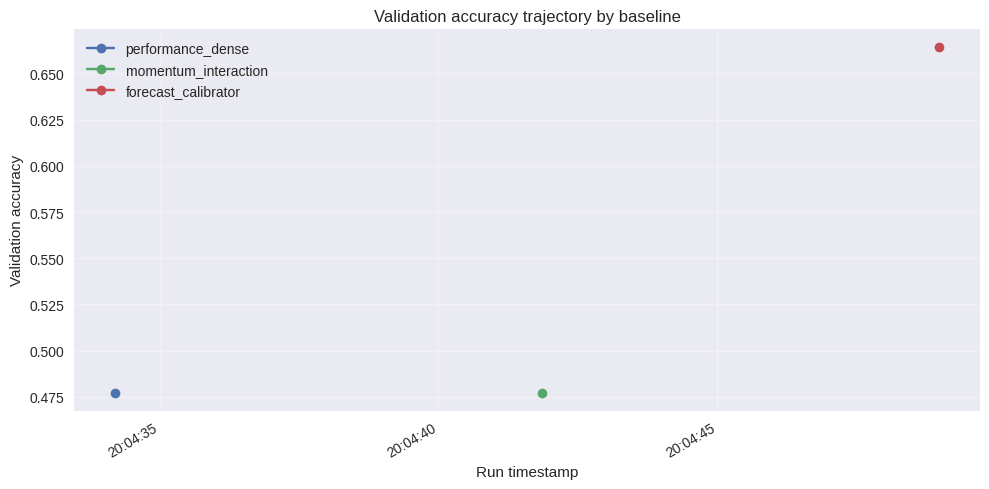

Saved validation accuracy history plot to /kaggle/working/experiments/run_20251023-200415/validation_accuracy_history.png


In [15]:

# Historical comparison versus prior runs
if RUN_LOG_PATH.exists():
    history_df = pd.read_csv(RUN_LOG_PATH)
    history_df["timestamp"] = pd.to_datetime(history_df["timestamp"], errors="coerce")
    history_df.sort_values("timestamp", inplace=True)

    latest_df = history_df[history_df["run_id"] == RUN_ID]
    best_df = history_df.sort_values("val_accuracy", ascending=False).drop_duplicates("baseline")
    comparison = latest_df.merge(
        best_df[["baseline", "val_accuracy", "test_accuracy", "run_id"]],
        on="baseline",
        suffixes=("_current", "_best"),
    )

    print("Most recent run vs historical best (by validation accuracy):")
    display(comparison[[
        "baseline",
        "val_accuracy_current",
        "val_accuracy_best",
        "test_accuracy_current",
        "test_accuracy_best",
        "run_id_best",
    ]])

    fig, ax = plt.subplots(figsize=(10, 5))
    for baseline in history_df["baseline"].unique():
        subset = history_df[history_df["baseline"] == baseline]
        ax.plot(subset["timestamp"], subset["val_accuracy"], marker="o", label=baseline)
    ax.set_title("Validation accuracy trajectory by baseline")
    ax.set_ylabel("Validation accuracy")
    ax.set_xlabel("Run timestamp")
    ax.grid(True, alpha=0.3)
    ax.legend()
    fig.autofmt_xdate()
    fig.tight_layout()
    plot_path = MODEL_ARTIFACT_DIR / "validation_accuracy_history.png"
    fig.savefig(plot_path, dpi=160)
    plt.show()
    print(f"Saved validation accuracy history plot to {plot_path}")
else:
    print("Run history file not found — this will be created after the first successful training run.")



## Next Steps
- Extend feature engineering with financial and odds datasets described in the README, maintaining the logging conventions used here.
- Layer on attribution analysis (approximate Shapley, LOO) by loading saved `model.keras` files and pairing them with cached train/validation datasets.
- Use the persisted `baseline_run_history.csv` to drive Kaggle dashboard widgets or automated alerts when new dataset versions shift model behaviour.
